In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
data = pd.read_csv('dynamic_pricing.csv')

In [3]:
data

Number_of_Riders  Number_of_Drivers Location_Category  \
0                  90                 45             Urban   
1                  58                 39          Suburban   
2                  42                 31             Rural   
3                  89                 28             Rural   
4                  78                 22             Rural   
..                ...                ...               ...   
995                33                 23             Urban   
996                84                 29             Urban   
997                44                  6          Suburban   
998                53                 27          Suburban   
999                78                 63             Rural   

    Customer_Loyalty_Status  Number_of_Past_Rides  Average_Ratings  \
0                    Silver                    13             4.47   
1                    Silver                    72             4.06   
2                    Silver                     0             3.99   
3                   Regular                    67             4.31   
4                   Regular                    74             3.77   
..                      ...                   ...              ...   
995                    Gold                    24             4.21   
996                 Regular                    92             4.55   
997                    Gold                    80             4.13   
998                 Regular                    78             3.63   
999                    Gold                    14             4.21   

    Time_of_Booking Vehicle_Type  Expected_Ride_Duration  \
0             Night      Premium                      90   
1           Evening      Economy                      43   
2         Afternoon      Premium                      76   
3         Afternoon      Premium                     134   
4         Afternoon      Economy                     149   
..              ...          ...                     ...   
995         Morning      Premium                      11   
996         Morning      Premium                      94   
997           Night      Premium                      40   
998           Night      Premium                      58   
999       Afternoon      Economy                     147   

     Historical_Cost_of_Ride  
0                 284.257273  
1                 173.874753  
2                 329.795469  
3                 470.201232  
4                 579.681422  
..                       ...  
995                91.389526  
996               424.155987  
997               157.364830  
998               279.095048  
999               655.065106  

[1000 rows x 10 columns]

In [5]:
data.describe()

Number_of_Riders  Number_of_Drivers  Number_of_Past_Rides  \
count       1000.000000        1000.000000           1000.000000   
mean          60.372000          27.076000             50.031000   
std           23.701506          19.068346             29.313774   
min           20.000000           5.000000              0.000000   
25%           40.000000          11.000000             25.000000   
50%           60.000000          22.000000             51.000000   
75%           81.000000          38.000000             75.000000   
max          100.000000          89.000000            100.000000   

       Average_Ratings  Expected_Ride_Duration  Historical_Cost_of_Ride  
count      1000.000000              1000.00000              1000.000000  
mean          4.257220                99.58800               372.502623  
std           0.435781                49.16545               187.158756  
min           3.500000                10.00000                25.993449  
25%           3.870000                59.75000               221.365202  
50%           4.270000               102.00000               362.019426  
75%           4.632500               143.00000               510.497504  
max           5.000000               180.00000               836.116419

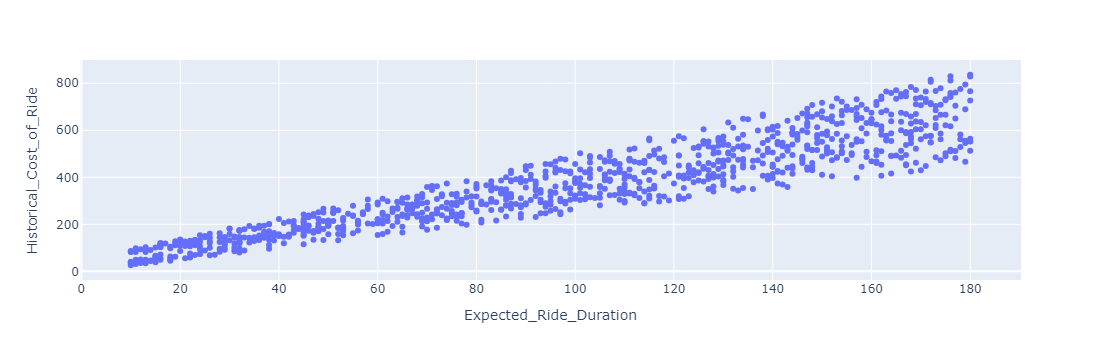

In [13]:
fig = px.scatter(data, x = data['Expected_Ride_Duration'], y = data['Historical_Cost_of_Ride'])
fig.show()

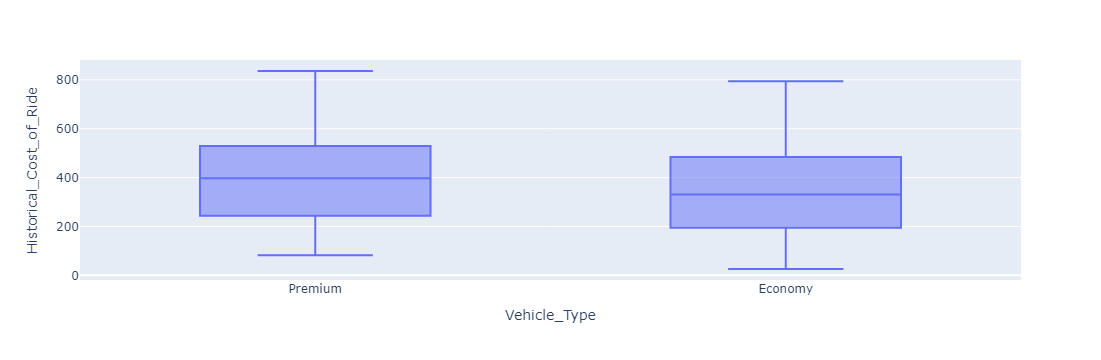

In [14]:
fig = px.box(data, x = data['Vehicle_Type'], y = data['Historical_Cost_of_Ride'])
fig.show()

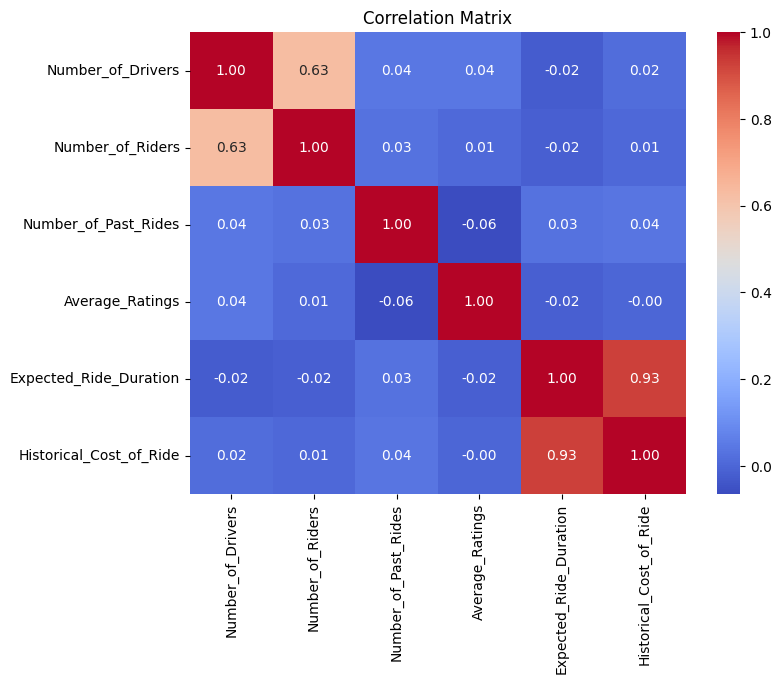

In [20]:
corr_data = data[['Number_of_Drivers', 'Number_of_Riders', 'Number_of_Past_Rides', 'Average_Ratings', 'Expected_Ride_Duration', 'Historical_Cost_of_Ride']]
corr_matrix = corr_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [59]:
high_demand_percentile = 75
low_demand_percentile = 25

data['demand_multiplier'] = np.where(data['Number_of_Riders'] > np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], low_demand_percentile))


high_supply_percentile = 75
low_supply_percentile = 25

data['supply_multiplier'] = np.where(data['Number_of_Drivers'] > np.percentile(data['Number_of_Drivers'], low_supply_percentile),
                                     np.percentile(data['Number_of_Drivers'], high_supply_percentile) / data['Number_of_Drivers'],
                                     np.percentile(data['Number_of_Drivers'], low_supply_percentile) / data['Number_of_Drivers'])

demand_threshold_high = 1.2  
demand_threshold_low = 0.8  
supply_threshold_high = 0.8  
supply_threshold_low = 1.2  

data['adjusted_ride_cost'] = data['Historical_Cost_of_Ride'] * (
    np.maximum(data['demand_multiplier'], demand_threshold_low) *
    np.maximum(data['supply_multiplier'], supply_threshold_high)
)



308637.3940429099


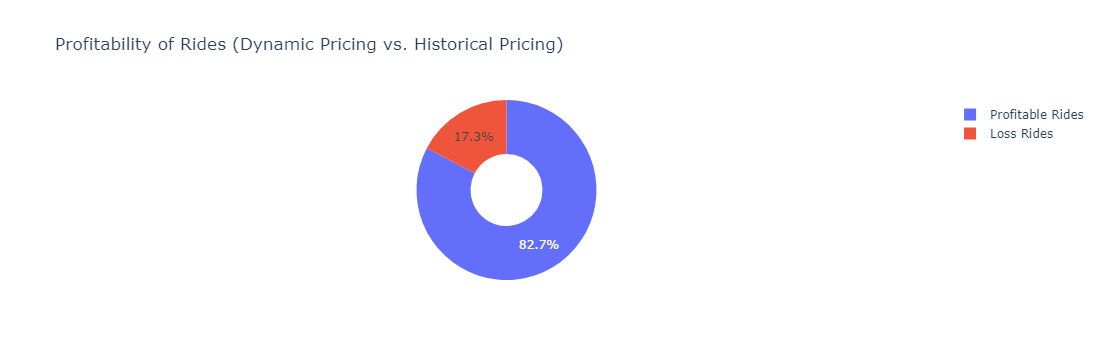

In [60]:

data['profit_percentage'] = ((data['adjusted_ride_cost'] - data['Historical_Cost_of_Ride']) / data['Historical_Cost_of_Ride']) * 100
profitable_rides = data[data['profit_percentage'] > 0]
net_profit = data['adjusted_ride_cost'] - data['Historical_Cost_of_Ride']
print(sum(net_profit))
loss_rides = data[data['profit_percentage'] < 0]


import plotly.graph_objects as go

profitable_count = len(profitable_rides)
loss_count = len(loss_rides)

labels = ['Profitable Rides', 'Loss Rides']
values = [profitable_count, loss_count]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.4)])
fig.update_layout(title='Profitability of Rides (Dynamic Pricing vs. Historical Pricing)')
fig.show()

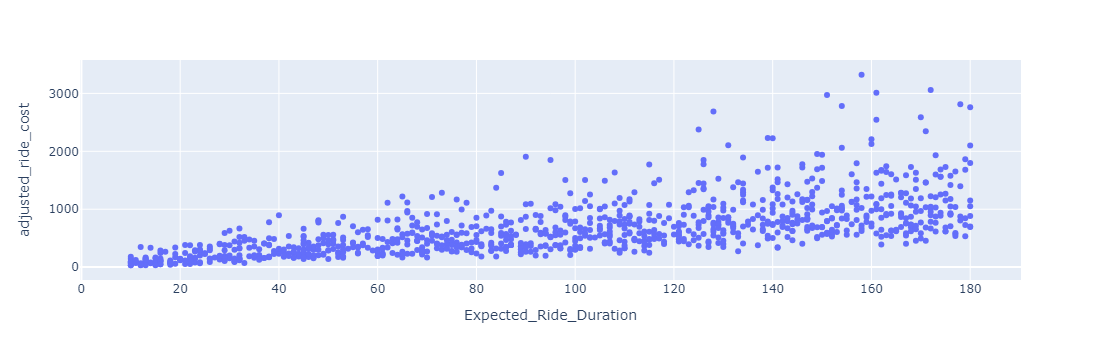

In [61]:
fig = px.scatter(data, 
                 x=data['Expected_Ride_Duration'], 
                 y=data['adjusted_ride_cost'],
                 )
fig.show()



In [62]:
import pandas as pd


one_hot_encoded = pd.get_dummies(data['Customer_Loyalty_Status'], prefix='Loyalty')


data_with_customer_loyalty = pd.concat([data, one_hot_encoded], axis=1)

data_with_customer_loyalty['Loyalty_Regular'] = data_with_customer_loyalty['Loyalty_Regular'].map(lambda x:1 if x == True else 0)
data_with_customer_loyalty['Loyalty_Gold'] = data_with_customer_loyalty['Loyalty_Gold'].map(lambda x:1 if x == True else 0)
data_with_customer_loyalty['Loyalty_Silver'] = data_with_customer_loyalty['Loyalty_Silver'].map(lambda x:1 if x == True else 0)

data_with_customer_loyalty.drop('Customer_Loyalty_Status', axis=1, inplace=True)

data_with_customer_loyalty


Number_of_Riders  Number_of_Drivers Location_Category  \
0                  90                 45             Urban   
1                  58                 39          Suburban   
2                  42                 31             Rural   
3                  89                 28             Rural   
4                  78                 22             Rural   
..                ...                ...               ...   
995                33                 23             Urban   
996                84                 29             Urban   
997                44                  6          Suburban   
998                53                 27          Suburban   
999                78                 63             Rural   

     Number_of_Past_Rides  Average_Ratings Time_of_Booking Vehicle_Type  \
0                      13             4.47           Night      Premium   
1                      72             4.06         Evening      Economy   
2                       0             3.99       Afternoon      Premium   
3                      67             4.31       Afternoon      Premium   
4                      74             3.77       Afternoon      Economy   
..                    ...              ...             ...          ...   
995                    24             4.21         Morning      Premium   
996                    92             4.55         Morning      Premium   
997                    80             4.13           Night      Premium   
998                    78             3.63           Night      Premium   
999                    14             4.21       Afternoon      Economy   

     Expected_Ride_Duration  Historical_Cost_of_Ride  demand_multiplier  \
0                        90               284.257273           1.111111   
1                        43               173.874753           1.450000   
2                        76               329.795469           1.050000   
3                       134               470.201232           1.098765   
4                       149               579.681422           1.950000   
..                      ...                      ...                ...   
995                      11                91.389526           0.825000   
996                      94               424.155987           1.037037   
997                      40               157.364830           1.100000   
998                      58               279.095048           1.325000   
999                     147               655.065106           1.950000   

     supply_multiplier  adjusted_ride_cost  profit_percentage  Loyalty_Gold  \
0             0.844444          266.710528          -6.172840             0   
1             0.974359          245.653817          41.282051             0   
2             1.225806          424.478684          28.709677             0   
3             1.357143          701.155452          49.118166             0   
4             1.727273         1952.472427         236.818182             0   
..                 ...                 ...                ...           ...   
995           1.652174          124.567897          36.304348             1   
996           1.310345          576.375440          35.887612             0   
997           1.833333          317.352408         101.666667             1   
998           1.407407          520.460581          86.481481             0   
999           0.603175         1021.901565          56.000000             1   

     Loyalty_Regular  Loyalty_Silver  
0                  0               1  
1                  0               1  
2                  0               1  
3                  1               0  
4                  1               0  
..               ...             ...  
995                0               0  
996                1               0  
997                0               0  
998                1               0  
999                0               0  

[1000 rows x 16 columns]

In [68]:
# if loyalty prefrence given to customers 
data_with_customer_loyalty['adjusted_ride_cost'] = np.where(
    (data_with_customer_loyalty['Loyalty_Gold'] == 1) | (data_with_customer_loyalty['Average_Ratings'] >= 4.5),
    np.minimum(data_with_customer_loyalty['Historical_Cost_of_Ride'], data_with_customer_loyalty['adjusted_ride_cost']),
    data_with_customer_loyalty['adjusted_ride_cost']
)
data_with_customer_loyalty

Number_of_Riders  Number_of_Drivers Location_Category  \
0                  90                 45             Urban   
1                  58                 39          Suburban   
2                  42                 31             Rural   
3                  89                 28             Rural   
4                  78                 22             Rural   
..                ...                ...               ...   
995                33                 23             Urban   
996                84                 29             Urban   
997                44                  6          Suburban   
998                53                 27          Suburban   
999                78                 63             Rural   

     Number_of_Past_Rides  Average_Ratings Time_of_Booking Vehicle_Type  \
0                      13             4.47           Night      Premium   
1                      72             4.06         Evening      Economy   
2                       0             3.99       Afternoon      Premium   
3                      67             4.31       Afternoon      Premium   
4                      74             3.77       Afternoon      Economy   
..                    ...              ...             ...          ...   
995                    24             4.21         Morning      Premium   
996                    92             4.55         Morning      Premium   
997                    80             4.13           Night      Premium   
998                    78             3.63           Night      Premium   
999                    14             4.21       Afternoon      Economy   

     Expected_Ride_Duration  Historical_Cost_of_Ride  demand_multiplier  \
0                        90               284.257273           1.111111   
1                        43               173.874753           1.450000   
2                        76               329.795469           1.050000   
3                       134               470.201232           1.098765   
4                       149               579.681422           1.950000   
..                      ...                      ...                ...   
995                      11                91.389526           0.825000   
996                      94               424.155987           1.037037   
997                      40               157.364830           1.100000   
998                      58               279.095048           1.325000   
999                     147               655.065106           1.950000   

     supply_multiplier  adjusted_ride_cost  profit_percentage  Loyalty_Gold  \
0             0.844444          266.710528          -6.172840             0   
1             0.974359          245.653817          41.282051             0   
2             1.225806          424.478684          28.709677             0   
3             1.357143          701.155452          49.118166             0   
4             1.727273         1952.472427         236.818182             0   
..                 ...                 ...                ...           ...   
995           1.652174           91.389526           0.000000             1   
996           1.310345          424.155987           0.000000             0   
997           1.833333          157.364830           0.000000             1   
998           1.407407          520.460581          86.481481             0   
999           0.603175          655.065106           0.000000             1   

     Loyalty_Regular  Loyalty_Silver  
0                  0               1  
1                  0               1  
2                  0               1  
3                  1               0  
4                  1               0  
..               ...             ...  
995                0               0  
996                1               0  
997                0               0  
998                1               0  
999                0               0  

[1000 rows x 16 columns]

136037.27043022247


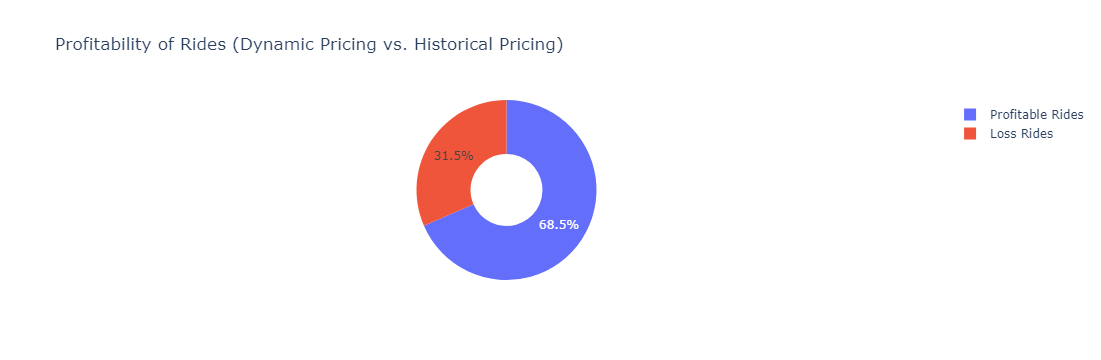

In [66]:
data_with_customer_loyalty['profit_percentage'] = ((data_with_customer_loyalty['adjusted_ride_cost'] - data_with_customer_loyalty['Historical_Cost_of_Ride']) / data_with_customer_loyalty['Historical_Cost_of_Ride']) * 100
net_profit = data_with_customer_loyalty['adjusted_ride_cost'] - data_with_customer_loyalty['Historical_Cost_of_Ride']
print(sum(net_profit))
profitable_rides = data_with_customer_loyalty[data_with_customer_loyalty['profit_percentage'] > 0]

loss_rides = data_with_customer_loyalty[data_with_customer_loyalty['profit_percentage'] < 0]


import plotly.graph_objects as go

profitable_count = len(profitable_rides)
loss_count = len(loss_rides)

labels = ['Profitable Rides', 'Loss Rides']
values = [profitable_count, loss_count]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.4)])
fig.update_layout(title='Profitability of Rides (Dynamic Pricing vs. Historical Pricing)')
fig.show()

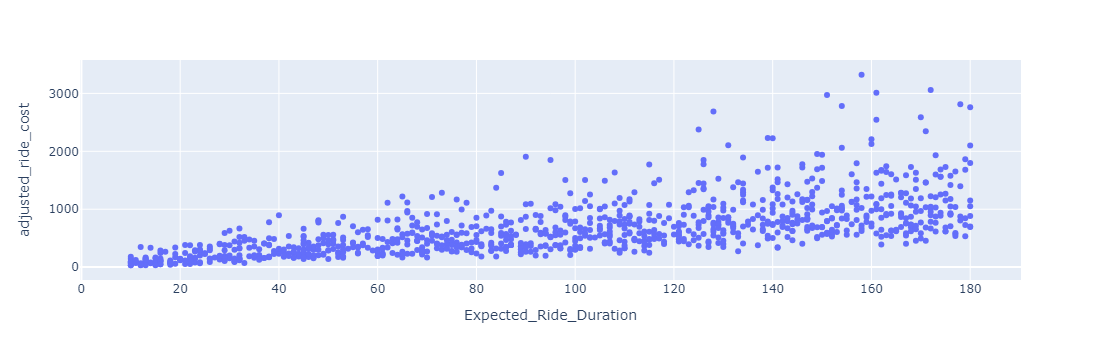

In [67]:
fig = px.scatter(data, 
                 x=data['Expected_Ride_Duration'], 
                 y=data['adjusted_ride_cost'],
                 )

fig.show()

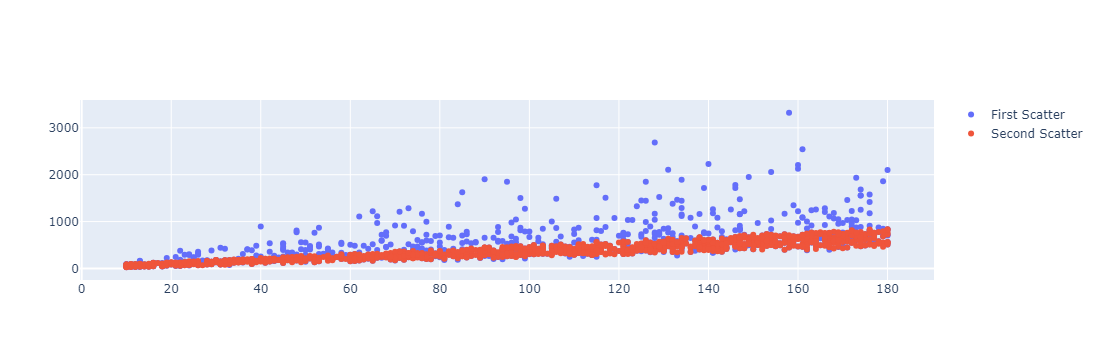

In [69]:
import plotly.graph_objects as go

# Create the first scatter plot
fig = go.Figure()

# Add the first scatter plot
fig.add_trace(go.Scatter(
    x=data_with_customer_loyalty['Expected_Ride_Duration'], 
    y=data_with_customer_loyalty['adjusted_ride_cost'],
    mode='markers',
    name='First Scatter'
))

# Add the second scatter plot (example data)
fig.add_trace(go.Scatter(
    x=data_with_customer_loyalty['Expected_Ride_Duration'],  # Replace with your actual column name
    y=data_with_customer_loyalty['Historical_Cost_of_Ride'],  # Replace with your actual column name
    mode='markers',
    name='Second Scatter'
))

# Show the combined plot
fig.show()


In [70]:
# from sklearn.preprocessing import minmax_scale
data.to_csv('transformed_data.csv', index = False)
data_with_customer_loyalty.to_csv('transformed_data_with_customer_loyalty.csv', index = False)

In [130]:
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
x = np.array(data[["Number_of_Riders", "Number_of_Drivers", "Expected_Ride_Duration"]])
y = np.array(data[["adjusted_ride_cost"]])

x = minmax_scale(x)
# y = minmax_scale(y)

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [83]:
# from sklearn.preprocessing import minmax_scale

# x_train, x_test = minmax_scale(x_train), minmax_scale(x_test)
# y_train, y_test = minmax_scale(y_train), minmax_scale(y_test)


In [131]:
y_train = y_train.ravel()
y_test = y_test.ravel()

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

In [146]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np


x = np.array(data[["Number_of_Riders", "Number_of_Drivers", "Expected_Ride_Duration"]])
y = np.array(data[["adjusted_ride_cost"]])

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()


x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=42)


model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
model.fit(x_train, y_train)


input_data = np.array([[100, 20, 60]])

input_data_scaled = scaler_x.transform(input_data)

predicted_cost_scaled = model.predict(input_data_scaled)

predicted_cost = scaler_y.inverse_transform(predicted_cost_scaled.reshape(-1, 1))
predicted_cost


array([[449.01231135]])

In [147]:
train_result = model.score(x_train, y_train)
train_result

0.9823159824485459

In [148]:
test_result = model.score(x_test, y_test)
test_result

0.8578833517250921

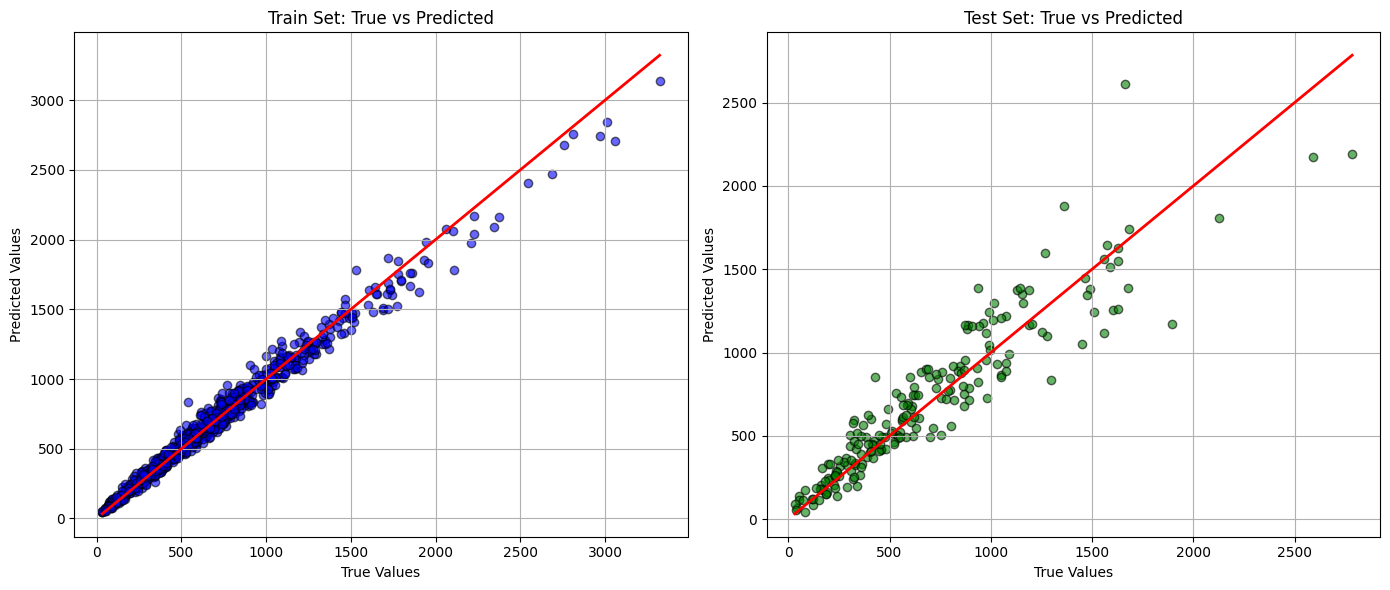

In [149]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on the training data
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Inverse transform predictions to original scale (if scaling was applied)
y_train_pred = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))
y_test_pred = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1))
y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Scatter plot for training data
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.scatter(y_train, y_train_pred, color='blue', edgecolor='k', alpha=0.6)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', lw=2)  # Line for perfect prediction
plt.title('Train Set: True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)

# Scatter plot for test data
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.scatter(y_test, y_test_pred, color='green', edgecolor='k', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # Line for perfect prediction
plt.title('Test Set: True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()


In [136]:
data_with_customer_loyalty

Number_of_Riders  Number_of_Drivers Location_Category  \
0                  90                 45             Urban   
1                  58                 39          Suburban   
2                  42                 31             Rural   
3                  89                 28             Rural   
4                  78                 22             Rural   
..                ...                ...               ...   
995                33                 23             Urban   
996                84                 29             Urban   
997                44                  6          Suburban   
998                53                 27          Suburban   
999                78                 63             Rural   

     Number_of_Past_Rides  Average_Ratings Time_of_Booking Vehicle_Type  \
0                      13             4.47           Night      Premium   
1                      72             4.06         Evening      Economy   
2                       0             3.99       Afternoon      Premium   
3                      67             4.31       Afternoon      Premium   
4                      74             3.77       Afternoon      Economy   
..                    ...              ...             ...          ...   
995                    24             4.21         Morning      Premium   
996                    92             4.55         Morning      Premium   
997                    80             4.13           Night      Premium   
998                    78             3.63           Night      Premium   
999                    14             4.21       Afternoon      Economy   

     Expected_Ride_Duration  Historical_Cost_of_Ride  demand_multiplier  \
0                        90               284.257273           1.111111   
1                        43               173.874753           1.450000   
2                        76               329.795469           1.050000   
3                       134               470.201232           1.098765   
4                       149               579.681422           1.950000   
..                      ...                      ...                ...   
995                      11                91.389526           0.825000   
996                      94               424.155987           1.037037   
997                      40               157.364830           1.100000   
998                      58               279.095048           1.325000   
999                     147               655.065106           1.950000   

     supply_multiplier  adjusted_ride_cost  profit_percentage  Loyalty_Gold  \
0             0.844444          266.710528          -6.172840             0   
1             0.974359          245.653817          41.282051             0   
2             1.225806          424.478684          28.709677             0   
3             1.357143          701.155452          49.118166             0   
4             1.727273         1952.472427         236.818182             0   
..                 ...                 ...                ...           ...   
995           1.652174           91.389526           0.000000             1   
996           1.310345          424.155987           0.000000             0   
997           1.833333          157.364830           0.000000             1   
998           1.407407          520.460581          86.481481             0   
999           0.603175          655.065106           0.000000             1   

     Loyalty_Regular  Loyalty_Silver  
0                  0               1  
1                  0               1  
2                  0               1  
3                  1               0  
4                  1               0  
..               ...             ...  
995                0               0  
996                1               0  
997                0               0  
998                1               0  
999                0               0  

[1000 rows x 16 columns]

In [141]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np


x_loyal = np.array(data_with_customer_loyalty[["Number_of_Riders", "Number_of_Drivers", "Expected_Ride_Duration", "Loyalty_Gold", "Average_Ratings"]])
y_loyal = np.array(data_with_customer_loyalty[["adjusted_ride_cost"]])

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x_scaled = scaler_x.fit_transform(x_loyal)
y_scaled = scaler_y.fit_transform(y_loyal.reshape(-1, 1)).ravel()


x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=42)


model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
model.fit(x_train, y_train)


input_data = np.array([[100, 20, 60, 0, 4.0]])

input_data_scaled = scaler_x.transform(input_data)

predicted_cost_scaled = model.predict(input_data_scaled)

predicted_cost = scaler_y.inverse_transform(predicted_cost_scaled.reshape(-1, 1))
predicted_cost


array([[443.74764274]])

In [142]:
train_result = model.score(x_train, y_train)
train_result

0.9737150021617339

In [143]:
test_result = model.score(x_test, y_test)
test_result

0.8140784967693308

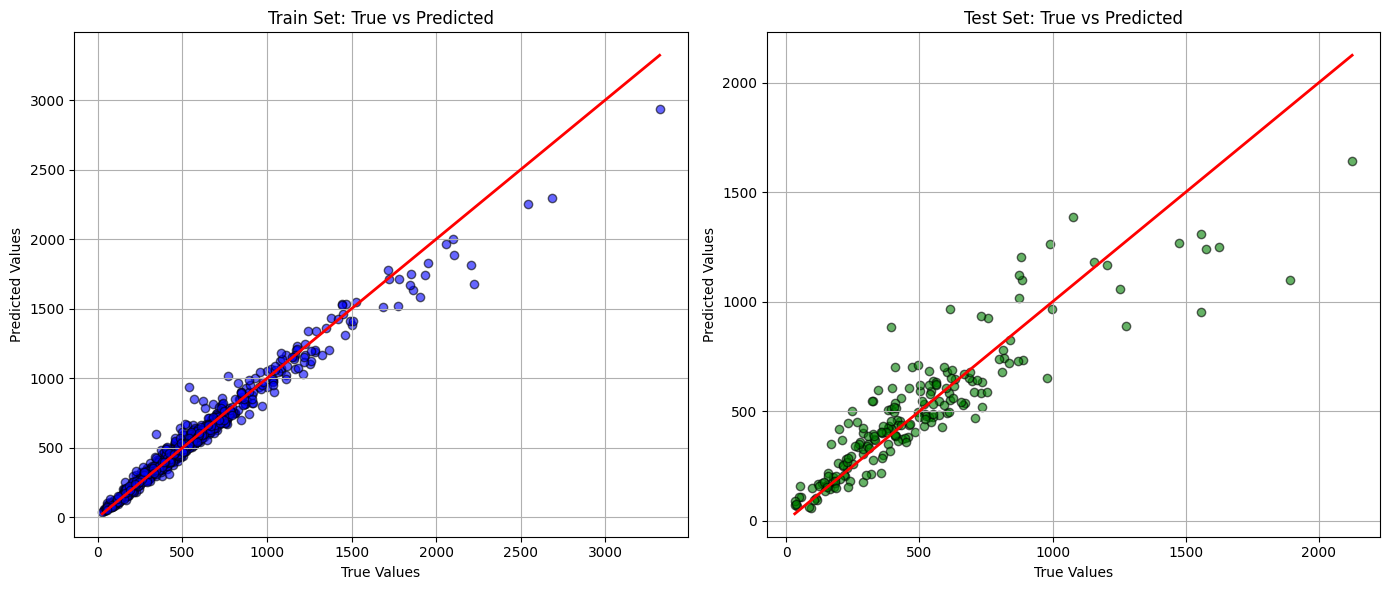

In [145]:
import matplotlib.pyplot as plt
import numpy as np

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

y_train_pred = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))
y_test_pred = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1))
y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  
plt.scatter(y_train, y_train_pred, color='blue', edgecolor='k', alpha=0.6)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', lw=2)  # Line for perfect prediction
plt.title('Train Set: True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)

# Scatter plot for test data
plt.subplot(1, 2, 2)  
plt.scatter(y_test, y_test_pred, color='green', edgecolor='k', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # Line for perfect prediction
plt.title('Test Set: True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()
